## Step 1: Introduction

In [1]:

#Some questions we brainstormed:

# Is it possible to make a high accuracy model that can predict wins and losses if given data on team performance?
# How much does the duration of a game impact the win statistics of different teams?
# Does opponent gold influence the team kills per minute and final result? If so, how much?



## Step 2: Data Cleaning and Exploratory Data Analysis

In [2]:
from lec_utils import *
import lec23_util as util
## This extracts out all of the code 
pd.options.plotting.backend = 'plotly'
df = pd.read_csv('eecs398Sheet.csv', usecols=["teamname", 
                                              "result",
                                              "team kpm",  
                                              "kills", 
                                              "deaths", 
                                              "firstmidtower", 
                                              "towers", 
                                              "totalgold"])
df = df.dropna()
# df = df[df["result"] != 1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = (
    train_test_split(df[['team kpm', 'totalgold']], df['result'], random_state=1)
)
fig = (
    X_train.assign(result=y_train.astype(str).replace({'1': 'Win', '0': 'Loss'}))
            .plot(kind='scatter', x='team kpm', y='totalgold', color='result', 
                  color_discrete_map={'Win': 'orange', 'Loss': 'blue'},
                  title='Relationship between total gold, team kpm, and final result of the match')
            .update_layout(
                xaxis=dict(title='Team KPM', range=[0, 2.5]),  # Adjust the range for x-axis
                yaxis=dict(title='Total Gold', range=[20000, 120000]),  # Adjust the range for y-axis
                width=800
            )
)
fig.show()


ModuleNotFoundError: No module named 'lec_utils'

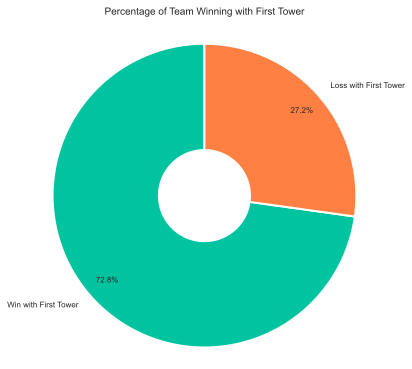

When getting first tower:
Win rate: 72.8%
Lose rate: 27.2%


In [ ]:
##bivariate analysis
first_tower_games = df[df['firstmidtower'] == 1]

win_rate = (first_tower_games['result'] == 1).mean() * 100
lose_rate = 100 - win_rate

labels = ['Win with First Tower', 'Loss with First Tower']
sizes = [win_rate, lose_rate]
colors = ['#00C49F', '#FF8042']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90,
        counterclock=True,
        pctdistance=0.85,
        radius=1,
        wedgeprops=dict(width=0.7),
        textprops={'fontsize': 8, 'fontfamily': 'sans-serif'})

plt.title('Percentage of Team Winning with First Tower', 
          pad=15, 
          size=10,
          fontfamily='sans-serif')
plt.axis('equal')
plt.show()

print(f"When getting first tower:")
print(f"Win rate: {win_rate:.1f}%")
print(f"Lose rate: {lose_rate:.1f}%")

In [ ]:
# Univariate analysis using KPM

kpm_plot = df['team kpm'].plot(
    kind='histogram',
    nbins=75,
    title='Kills per Minute (KPM) Distribution Across All Games',
    width=800,
    height=500
)

kpm_plot.update_layout(
    xaxis_title='Team KPM',
    yaxis_title='Number of Games'
)

kpm_plot.show()

print(f"Mean KPM: {df['team kpm'].mean():.2f}")
print(f"Median KPM: {df['team kpm'].median():.2f}")
print(f"Std: {df['team kpm'].std():.2f}")

Mean KPM: 0.47
Median KPM: 0.43
Std: 0.26


In [ ]:
kpm_plot.write_html('../league-of-legends-analysis/assets/kpm_univariate.html', include_plotlyjs='cdn')

In [ ]:
# Univeriate analysis using Towers
towers_plot = df['towers'].value_counts().sort_index().plot(
    kind='bar',
    title='Towers Destroyed By a Team In a Single Game',
    width=800,
    height=500
)

towers_plot.update_layout(
    xaxis_title='Number of Towers Taken',
    yaxis_title='Number of Games'
)

towers_plot.show()

print(f"Mean towers taken: {df['towers'].mean():.2f}")
print(f"Mode: {df['towers'].mode().iloc[0]}")
print(f"Median: {df['towers'].median():.2f}")

Mean towers taken: 6.05
Mode: 9.0
Median: 7.00


In [3]:
# Made a scatter plot to shpw diversity of the data we are working with here.
df2 = pd.read_csv('eecs398Sheet.csv', usecols=["teamname", 
                                              "teamid",
                                              "result",
                                              "team kpm",  
                                              "kills", 
                                              "deaths", 
                                              "firstmidtower", 
                                              "towers", 
                                              "totalgold"])
df2 = df.dropna()
fig = px.scatter(
    df2, 
    x="team kpm", 
    y="totalgold", 
    color="teamname", 
    hover_data=["result", "kills", "deaths"], 
    title="Scatter Plot of Total Gold vs Team KPM",
    labels={"totalgold": "Total Gold", "team kpm": "Team KPM"}
)

# Show the plot
fig.show()



NameError: name 'pd' is not defined

In [4]:
import numpy as np

import numpy as np
import pandas as pd


#Made the combined DataFrame here. This part is critical for our model.
df2 = df[df["result"] != 1]
df4 = df[df["result"] != 0]
df2.reset_index()
columns = len(df2) // 90
df2['group'] = np.arange(len(df2)) // columns
df2['group'] = df2['group'].clip(upper=90 - 1)
aggregated_df = df2.groupby('group')[['team kpm', 'deaths', 'totalgold', 'firstmidtower']].mean().reset_index()
aggregated_df['result'] = 0
print(aggregated_df)
df4.reset_index()
columnname = len(df4) // 90
print(columnname)
df4['group'] = np.arange(len(df4)) // columns
df4['group'] = df4['group'].clip(upper=90 - 1)
aggregated_df2 = df4.groupby('group')[['team kpm', 'deaths', 'totalgold', 'firstmidtower']].mean().reset_index()
aggregated_df2['result'] = 1
print(aggregated_df2)
combined_df = pd.concat([aggregated_df, aggregated_df2], ignore_index=True)
print(combined_df)

df2.reset_index()
columns = len(df2) // 90
df2['group'] = np.arange(len(df2)) // columns
df2['group'] = df2['group'].clip(upper=90 - 1)
aggregated_df = df2.groupby('group')[['team kpm', 'deaths', 'totalgold', 'firstmidtower']].mean().reset_index()
print(aggregated_df)



ModuleNotFoundError: No module named 'numpy'

## Step 3: Framing a Prediction Problem

In [34]:
# We are predicting whether or not a team wins a game based on the statistics we perceive 
# to have the highest impact on winning: team kills per minute, the first to capture the mid-tower,
# the total gold of a team during the game, and the number of deaths the team accrued. 

## Step 4: Baseline Model

[[0.01 0.99]]
1.0


/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



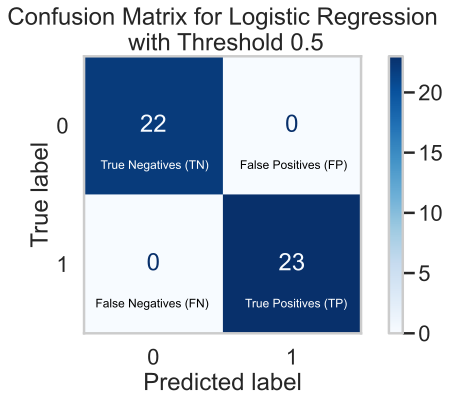

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import lec25_util
#We run logistical regression on the combined DF split into bins.
#Takes the train test split on the combined DF.
X_train, X_test, y_train, y_test = (
    train_test_split(combined_df[['team kpm', 'totalgold', 'firstmidtower']], combined_df['result'], random_state=1)
)

def chooseWinner(X_train, y_train):
    numeric_features = ['team kpm', 'totalgold', 'firstmidtower']
    numeric_transformer = StandardScaler() ##Standardize all of the numeric features.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features) ## Column Transformed
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression()) ## Pipeline into a Logistic Regression model.
    ])
    pipeline.fit(X_train, y_train)
    return pipeline
pipeline = chooseWinner(X_train, y_train)
pipeline
input_data = pd.DataFrame([{ # Here Input the data used for predictions.
    'team kpm': 0.6,
    'totalgold': 58000,
    'firstmidtower' : 1
}])

predicted_result = pipeline.predict_proba(input_data) # Predicts the Loss-Win rate.
predicted_accuracy = pipeline.score(X_test, y_test) # Model Accuracy
print(predicted_result)
print(predicted_accuracy)
lec25_util.show_confusion(X_test, y_test, T=0.5) # Outputs the confusion matrix,

[[0.37 0.63]]
0.8617442079487663


/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



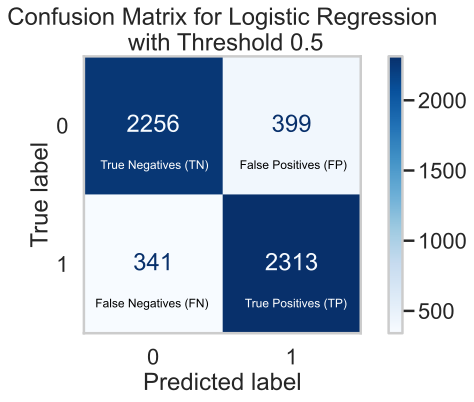

In [20]:
import pandas as pd
import lec25_util
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

#We run logistical regression on the entire DF of thousands of results.
#Takes the train test split on the entire DF.
#Steps followed below are exactly like the last code block.
X_train, X_test, y_train, y_test = (
    train_test_split(df[['team kpm', 'totalgold', 'firstmidtower']], df['result'], random_state=1)
)

def chooseWinner(X_train, y_train):
    numeric_features = ['team kpm', 'totalgold', 'firstmidtower']
    numeric_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression())
    ])
    pipeline.fit(X_train, y_train)
    return pipeline
pipeline = chooseWinner(X_train, y_train)
pipeline
input_data = pd.DataFrame([{
    'team kpm': 0.6,
    'totalgold': 38000,
    'firstmidtower' : 1
}])

predicted_result = pipeline.predict_proba(input_data)
predicted_accuracy = pipeline.score(X_test, y_test)
print(predicted_result)
print(predicted_accuracy)
lec25_util.show_confusion(X_test, y_test, T=0.5)

## Step 5: Final Model

0.7233000565078169
73


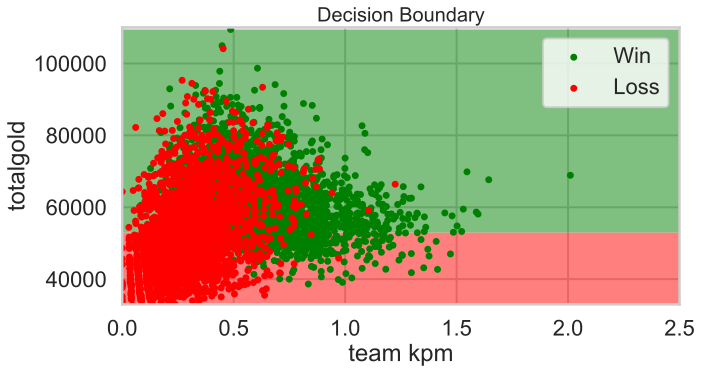

                          teamname  result  kills  deaths  team kpm  towers  \
10               BRION Challengers       0      9      19      0.32     3.0   
11        Nongshim Esports Academy       1     19       9      0.67     6.0   
22              T1 Esports Academy       0      3      16      0.09     3.0   
...                            ...     ...    ...     ...       ...     ...   
149903  Córdoba Patrimonio eSports       0     13      23      0.38     2.0   
149914                unknown team       1     22       9      0.79    10.0   
149915  Córdoba Patrimonio eSports       0      9      22      0.32     3.0   

        firstmidtower  totalgold  
10                1.0      47070  
11                0.0      52617  
22                0.0      57629  
...               ...        ...  
149903            0.0      56896  
149914            1.0      59933  
149915            0.0      44859  

[21233 rows x 8 columns]


In [21]:
# Model 1 Possibility - kNN Neigbbors with entire dataset. This is inefficient! And also more inaccurate!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#Using Train Test Split on the large dataframe with entire dataset.
X_train, X_test, y_train, y_test = (
    train_test_split(df[['team kpm', 'totalgold']], df['result'], random_state=1)
)
model_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {'n_neighbors': range(1, 100)} ## Use GridSearchCV to find the best k-Value
)
model_knn.fit(X_test, y_test)
print(model_knn.score(X_test, y_test))
# Visualize decision boundary
best_k = model_knn.best_params_['n_neighbors']
print(best_k) # Outputs the best_k value of 73. Pretty large number.
#Output the chart
util.show_decision_boundary(model_knn.best_estimator_, X_test, y_test, 
                            title='Decision Boundary')
plt.xlim(0, 2.5)  # Set x-axis range
plt.ylim(33000, 110000)  # Set y-axis range
plt.show()
print(df)


1.0
1


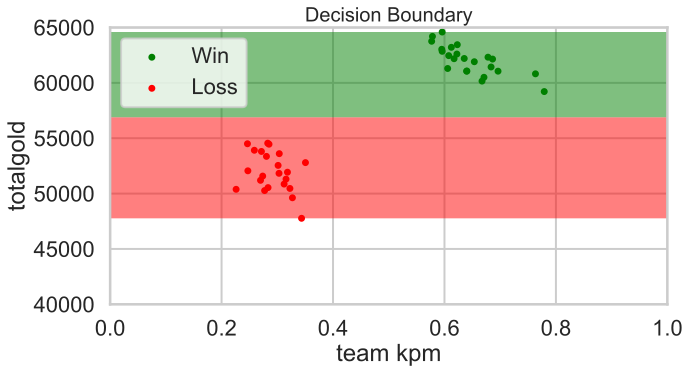

In [22]:
#Model 2: kNN Neighbors using Bins. Accuracy is far better!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#Train Test Split data on the smaller dataframe.
X_train, X_test, y_train, y_test = (
    train_test_split(combined_df[['team kpm', 'totalgold']], combined_df['result'], random_state=1)
)
model_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {'n_neighbors': range(1, 5)} #Use GridSearchCV to find best k value. It is 1 in this case.
)
model_knn.fit(X_test, y_test)
print(model_knn.score(X_test, y_test))
# Visualize decision boundary
best_k = model_knn.best_params_['n_neighbors']
print(best_k)
util.show_decision_boundary(model_knn.best_estimator_, X_test, y_test, 
                            title='Decision Boundary')
plt.xlim(0,1)  # Set x-axis range
plt.ylim(40000, 65000)  # Set y-axis range
plt.show()

[[0.21 0.79]]
0.956300621585986


/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



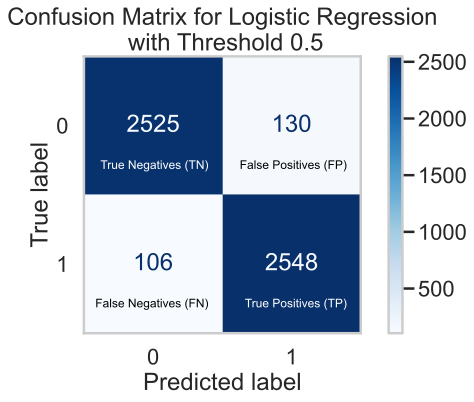

In [23]:
#Model 3 - Improved Initial Model as seen by the inclusion of deaths, the quantiled transformer on 3 columns
import pandas as pd
import lec25_util
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = (
    train_test_split(df[['team kpm', 'totalgold', 'firstmidtower', 'deaths']], df['result'], random_state=1)
)

def chooseWinner(X_train, y_train):
    numeric_features_normal = ['firstmidtower']
    numeric_features_quantiled = ['team kpm', 'totalgold', 'deaths']
    numeric_transformer = StandardScaler()
    quantiled_transformer = QuantileTransformer() # Utilize QuantileTransformer to turn unnormal distributions into normal distributions.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features_normal),
            ('quant', quantiled_transformer, numeric_features_quantiled)
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression()) # Used Logistical Regression here
    ])
    pipeline.fit(X_train, y_train) #Fit the pipeline here.
    return pipeline
pipeline = chooseWinner(X_train, y_train)
pipeline
input_data = pd.DataFrame([{
    'team kpm': 0.6,
    'totalgold': 38000,
    'firstmidtower' : 1,
    'deaths' : 10
}])

predicted_result = pipeline.predict_proba(input_data)
predicted_accuracy = pipeline.score(X_test, y_test)
print(predicted_result)
print(predicted_accuracy)
lec25_util.show_confusion(X_test, y_test, T=0.5) #Output the decision matrix here. 


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'classifier__max_depth': 6}


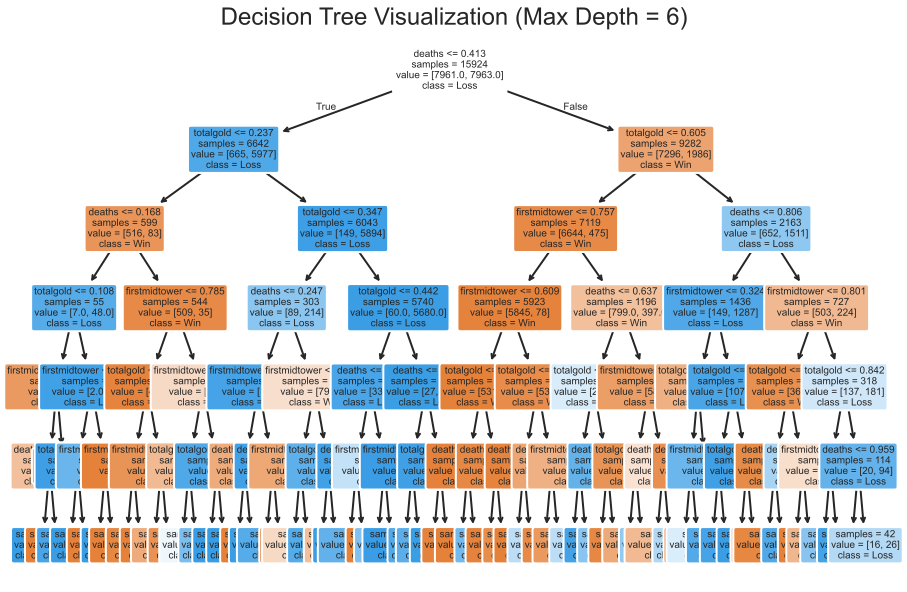

Test Accuracy: 0.9431154643058957


In [24]:
#Model 4 Uses Decision Tree with a hyperparameter using GridSearchCV to determine the best tree depth.
# The depth of this tree is pretty deep because of the amount of data, and is a little hard to read.
# This model does have a far better accuracy, however, making it a stronger improvement from our initial model!
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
# Complete train test split on the large dataframe.
X_train, X_test, y_train, y_test = train_test_split(
    df[['team kpm', 'totalgold', 'firstmidtower', 'deaths']], df['result'], random_state=1
)

def chooseWinner(X_train, y_train):
    numeric_features_normal = ['firstmidtower']
    numeric_features_quantiled = ['team kpm', 'totalgold', 'deaths']
    numeric_transformer = StandardScaler() # Using Standard Scaler.
    quantiled_transformer = QuantileTransformer() # Using Quantile Transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features_normal),
            ('quant', quantiled_transformer, numeric_features_quantiled)
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=1)) #Applying Decision Tree Classifier.
    ])
    
    return pipeline
pipeline = chooseWinner(X_train, y_train)
param_grid = {
    'classifier__max_depth': range(1,10),  # Depth of the tree. Using a range of values and having GridSearchCV finding the 
}
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_
best_tree = best_pipeline.named_steps['classifier']
plt.figure(figsize=(15, 10))
plot_tree(
    best_tree,
    feature_names=['team kpm', 'totalgold', 'firstmidtower', 'deaths'],
    class_names=['Win', 'Loss'], 
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False
)
plt.title("Decision Tree Visualization (Max Depth = 6)")
plt.show()
predicted_result = best_pipeline.predict(X_test)
predicted_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy:", predicted_accuracy)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'classifier__max_depth': 1}


/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (108). n_quantiles is set to n_samples.
  warnings.warn(
/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (108). n_quantiles is set to n_samples.
  warnings.warn(
/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (108). n_quantiles is set to n_samples.
  warnings.warn(
/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (108). n_quantiles is set to n_samples.
  warnings.warn(
/Users/aveekdutta/miniforge3/envs/pds/lib/python3.10

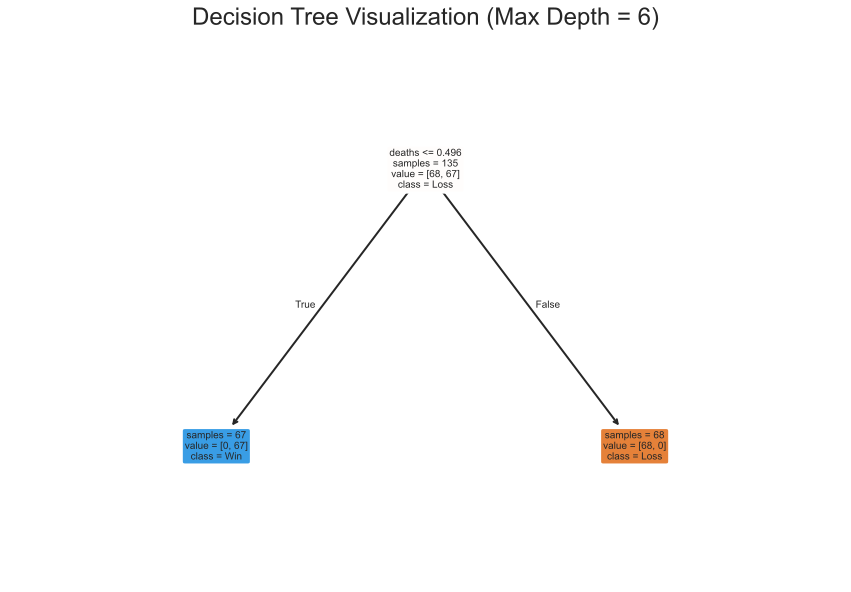

Test Accuracy: 1.0


In [25]:
#Model 5 Uses Decision Tree with a hyperparameter using GridSearchCV to determine the best tree depth.
# The depth of this tree is pretty small because the cpmbinedDF is binned, so this model is far more usable.
# This model does has a perfect accuracy!

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(
    combined_df[['team kpm', 'totalgold', 'firstmidtower', 'deaths']], combined_df['result'], random_state=1
)

def chooseWinner(X_train, y_train):
    numeric_features_normal = ['firstmidtower']
    numeric_features_quantiled = ['team kpm', 'totalgold', 'deaths']
    numeric_transformer = StandardScaler()
    quantiled_transformer = QuantileTransformer()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features_normal),
            ('quant', quantiled_transformer, numeric_features_quantiled)
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=1))
    ])
    
    return pipeline
pipeline = chooseWinner(X_train, y_train)
param_grid = {
    'classifier__max_depth': range(1,10),  # Depth of the tree
}
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_
best_tree = best_pipeline.named_steps['classifier']
plt.figure(figsize=(15, 10))
plot_tree(
    best_tree,
    feature_names=['team kpm', 'totalgold', 'firstmidtower', 'deaths'],
    class_names=['Loss', 'Win'], 
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False
)
plt.title("Decision Tree Visualization (Max Depth = 6)")
plt.show()
predicted_result = best_pipeline.predict(X_test)
predicted_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy:", predicted_accuracy)